### Figure 4 
- Sliding template during sleep deprivation
- Correlation across time window

### load data

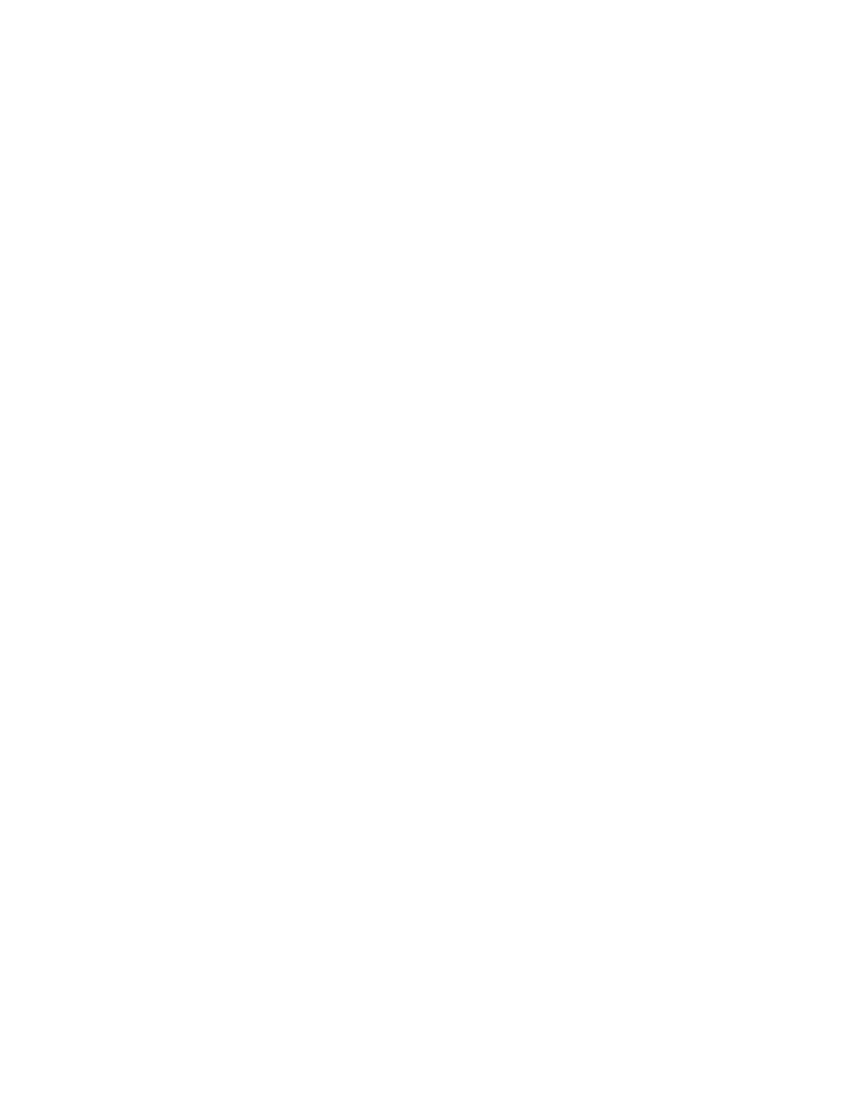

In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats

group = ['nsd','sd']
grpdata = subjects.GroupData()
pf_norm_tuning = grpdata.pf_norm_tuning

fig = Fig(grid=(5, 4), hspace=0.45, wspace=0.4)
filename = subjects.figpath_sd / 'figure4'
caption = 'Place cells: \n(A) Place fields recorded during NSD and SD sessions.'

### pf tuning

In [14]:
from scipy.ndimage import gaussian_filter1d
pf_cmaps = ['Purples','Oranges']
for i, grp in enumerate(group):
    df = pf_norm_tuning[pf_norm_tuning['grp']==grp].drop(columns='grp')
    tunings = df.to_numpy()
    x = df.columns.values.astype('float')
    y = np.arange(tunings.shape[0])

    sort_ind = np.argsort(np.argmax(tunings,axis=1))
    tunings = gaussian_filter1d(tunings[sort_ind,:],sigma=0.7,axis=1)


    ax = fig.subplot(fig.gs[:2,i])
    ax.pcolormesh(x,y,tunings,cmap='bwr',rasterized=True)
    ax.set_title(grp.upper())
    ax.set_xticks([0,1])
    ax.set_xlabel('Position')
    if i==0:
        ax.set_ylabel('Neurons')
        fig.panel_label(ax,'A')


### saving

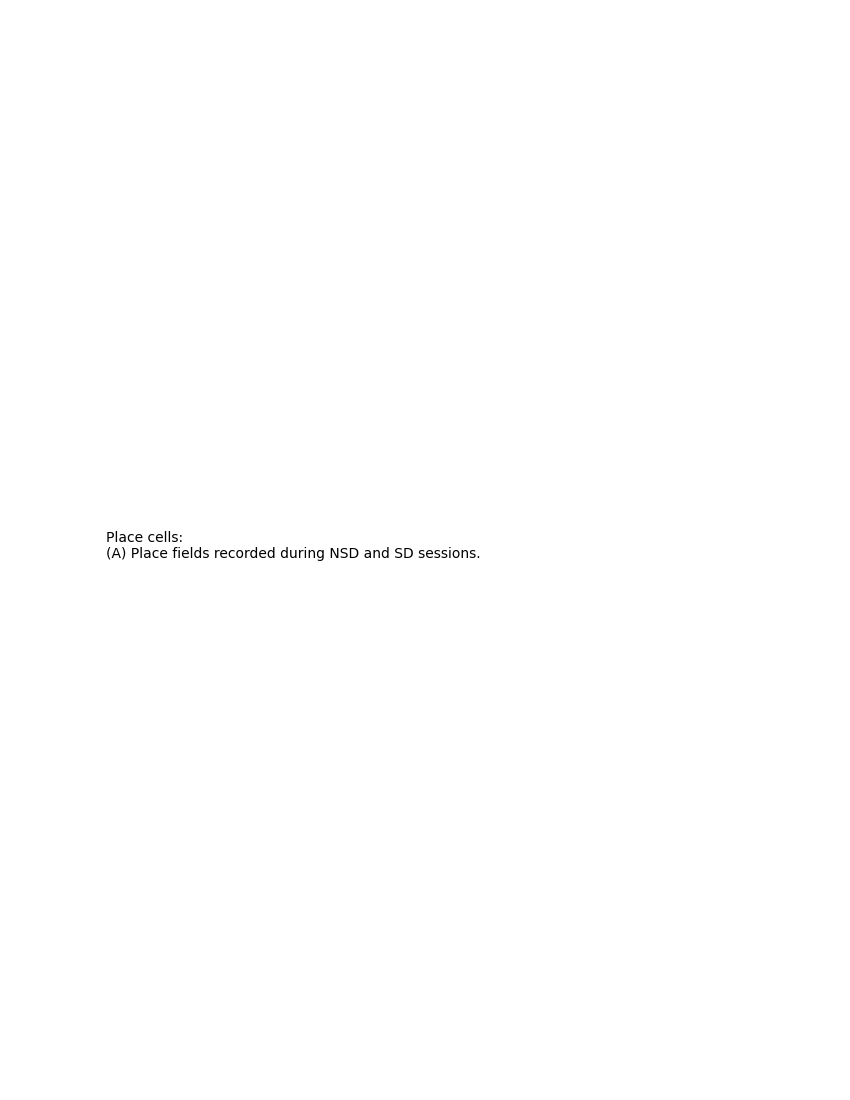

In [15]:
fig.savefig(filename,caption=caption)